In [36]:
from __future__ import print_function
from __future__ import division
import calendar
from collections import defaultdict, OrderedDict
import datetime
import dateutil.parser as dparser
from glob import glob
import logging
import matplotlib.pyplot as plt
import matplotlib.path as mplpath
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
import os
import pandas as pd
import skimage
import skimage.io as skio
from skimage import draw
import subprocess
import time
import ujson as json

from optical_vessel_detection.core import img_utils as iutils
from optical_vessel_detection.core import planet_utils as putils
from optical_vessel_detection.core.annotation_utils import get_labeled_props
from optical_vessel_detection.support.regions import reduced_study_area, \
                                                        approximate_simplified_nk_eez, full_study_area
from optical_vessel_detection.support import notebook_utils
from optical_vessel_detection.support.notebook_utils import path2sceneid, path2datestr
from optical_vessel_detection.support.info import fully_annotated, aois_by_date
from optical_vessel_detection.support import counting_tools

%matplotlib inline

proj_id = os.environ['PROJ_ID']

## Process/Load Info

The strategy here is to put an AOI around the fleet clusters. On days where sea
conditions are favorable, this can be a simple box, while on days where the sea
conditions are challenging we try to draw a tight border around the vessels.
Below we inspect scenes that are part of the cluster to identify the true
clusters and evaluate the sea state.

These instructions are specific to GFW's setup. You will need to adapt this
your specific situation. 

`mkdir data/inspect_scratch`

Then:

In [37]:
scene_map = notebook_utils.create_scene_map(
    f'{proj_id}.machine_learning_production.planet_scene_info')

detections_map = notebook_utils.create_detections_map(
    f'{proj_id}.machine_learning_production.detected_pair_trawlers_1_1_aug')

paths = (
    glob("../../../../image-vessel-identification/data/paper/aoi_annotations_rnd1/*.png")           
  + glob('../../../../image-vessel-identification/data/paper/aoi_annotations_rnd2/*.tif')
  + glob('../../../../image-vessel-identification/data/paper/aoi_annotations_rnd3/*.tif')
      )

annotations_map = notebook_utils.create_annotations_map(paths, 
                                    'gs://machine-learning-production/planet_images/nk_detection/',
                                    f'{proj_id}:machine_learning_dev_ttl_120d.annotations_20')

Downloading: 100%|██████████| 4941/4941 [00:01<00:00, 4600.38rows/s]


20170627
20170806
20171024
20180514
20180602
20180715
20180731
20180826
20180911
20180917
20180929
Skipping 20180929_010750_104e
20181008
Skipping 20181008_013024_1008
Skipping 20181008_013026_1008
20181102


## Mean Area of the AOIs

In [38]:
# Pulled from TrawlerCount results

dates_2017 = [u'20170528',
 u'20170627',
 u'20170715',
 u'20170806',
 u'20170908',
 u'20170926',
 u'20171024',
 u'20171105']

dates_2018 = [u'20180421',
 u'20180514',
 u'20180522',
 u'20180602',
 u'20180622',
 u'20180715',
 u'20180731',
 u'20180814',
 u'20180826',
 u'20180911',
 u'20180927',
 u'20181008',
 u'20181102',
 u'20181115']

In [39]:
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

subareas = []
for k in (dates_2017 + dates_2018):
    v = aois_by_date[k]
    subarea = 0
    for aoi in v:
        y = np.array([y for (_, y) in aoi])
        y0 = np.mean(y)
        x_scale = np.cos(np.radians(y0))
        x =  np.array([x_scale * x for (x, _) in aoi])
        subarea += PolyArea(x, y)
    km2_per_deg_lat2 = 111 ** 2
    subarea *= km2_per_deg_lat2
    subareas.append(subarea)

print("mean aoi area", np.mean(subareas))
print("media aoi area", np.median(subareas))
print("stdev aoi area", np.std(subareas))
print("min aoi area", np.min(subareas))
print("max aoi area", np.max(subareas))

mean aoi area 9240.753705689132
media aoi area 7418.677068663028
stdev aoi area 5401.460532302572
min aoi area 0.0
max aoi area 21729.30701190274


In [40]:
subareas = []
widths = []
heights = []
for scene in scene_map.values():
    aoi = json.loads(scene.boundary)
    y = np.array([d['lat'] for d in aoi])
    y0 = np.mean(y)
    x_scale = np.cos(np.radians(y0))
    x =  np.array([x_scale * d['lon'] for d in aoi])
    km2_per_deg_lat2 = 111 ** 2
    subarea = PolyArea(x, y) * km2_per_deg_lat2
    assert len(x) == 5
    km_per_deg_lat = 111
    ds = []
    for i in range(4):
        ds.append(np.hypot(x[i] - x[i+1], y[i] - y[i+1]))
    d02 = 0.5 * (ds[0] + ds[2]) * km_per_deg_lat
    d13 = 0.5 * (ds[1] + ds[3]) * km_per_deg_lat
    widths.append(max(d02, d13))
    heights.append(min(d02, d13))
    subareas.append(subarea)

mean_scene_area = np.mean(subareas)
print("mean scene area", np.mean(subareas))
print("media scene area", np.median(subareas))
print("stdev scene area", np.std(subareas))
print("min scene area", np.min(subareas))
print("max scene area", np.max(subareas))
print()
print("mean scene width", np.mean(widths))
print("media scene width", np.median(widths))
print("stdev scene width", np.std(widths))
print("min scene width", np.min(widths))
print("max scene width", np.max(widths))
print()
print("mean scene height", np.mean(heights))
print("media scene height", np.median(heights))
print("stdev scene height", np.std(heights))
print("min scene height", np.min(heights))
print("max scene height", np.max(heights))

mean scene area 204.5264681999433
media scene area 211.3114694087135
stdev scene area 20.01047520372135
min scene area 70.75882400950468
max scene area 323.15417448033986

mean scene width 25.11135322835538
media scene width 25.56589301223321
stdev scene width 1.2860474860742561
min scene width 15.598132247154386
max scene width 33.30882789128827

mean scene height 8.124532102750905
media scene height 8.264532274066733
stdev scene height 0.4654167947461797
min scene height 4.5675012214411845
max scene height 13.216049062377337


In [41]:
# Number of scenes we did in the first round of classification before we narrowed down the day selection
lsstr = subprocess.check_output([
    'gsutil', 'ls', 
    'gs://machine-learning-production/planet_paper/model_1_1/test_gpu_image_detections_1_1L/*/detections/*.json' 
    ])
ls_paths = lsstr.strip().split(b'\n')
counts = len(ls_paths)
print("Scenes processed", counts)
print("Area processed {:.2f} million km2".format(counts * mean_scene_area / 1e6))

Scenes processed 16817
Area processed 3.44 million km2


In [42]:
# Count number of scenes that is in the reduced study area over all dates.
scenes_in_aois = set()
dates = [u'20170528', u'20170627', u'20170715', u'20170806', u'20170908',
         u'20170926', u'20171024', u'20171105', u'20180421', u'20180514',
         u'20180522', u'20180602', u'20180622', u'20180715', u'20180731',
         u'20180814', u'20180826', u'20180911', u'20180927', u'20181008',
         u'20181102', u'20181115']
for date in dates:
    aois = aois_by_date[date]
    scenes = counting_tools.find_scenes_in_aois([date], [reduced_study_area], reduced_study_area, scene_map)
    scenes_in_aois |= set(scenes)

print("Total scenes in reduced study ares;",len(scenes_in_aois))
print("Over:", len(dates))

Total scenes in reduced study ares; 11207
Over: 22


## Area of Study Area

In [43]:
subareas = []
for aoi in [reduced_study_area]:
    y = np.array([y for (_, y) in aoi])
    y0 = np.mean(y)
    x_scale = np.cos(np.radians(y0))
    x =  np.array([x_scale * x for (x, _) in aoi])
    subarea = PolyArea(x, y)
    km2_per_deg_lat = 111 ** 2
    subarea *= km2_per_deg_lat
    subareas.append(subarea)
    
print('study area =', subareas[-1], 'km2')

study area = 90223.7665373474 km2


## Choosing AOIs

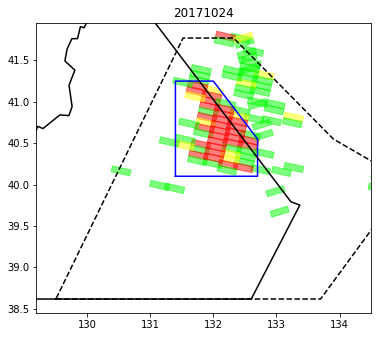

In [44]:
def lonlat_from_scene(scene):
    bounds = json.loads(scene.boundary)
    lons = [y['lon'] for y in bounds]
    lats = [y['lat'] for y in bounds]
    return lons, lats

def plot_scene_density(date, source, ax, valid_area=full_study_area, aois=()):
    df = source[date]
    detect_pts = [(x.longitude, x.latitude) for x in df.itertuples()]  
    if len(detect_pts):
        for scene_id in scene_map:
            if scene_id.startswith(date):
                scene = scene_map[scene_id]
                lons, lats = lonlat_from_scene(scene)
                is_valid = any(counting_tools.create_valid_area_mask(lons, lats, valid_area))
                if is_valid:
                    pts_in_scene = (df.scene_id == scene_id).sum()
                    if pts_in_scene == 0:
                        continue
                    if pts_in_scene >= 5:
                        color = (1, 0, 0)
                    elif pts_in_scene >= 3:
                        color = (1, 1, 0)
                    elif pts_in_scene >= 1:
                        color = (0, 1, 0)
                    box = ax.fill(lons, lats, color=color, alpha=0.5)
    for aoi in aois:
        lons = [x[0] for x in aoi]
        lats = [x[1] for x in aoi]
        ax.plot(lons, lats, 'b')
            
    eez = ax.plot(approximate_simplified_nk_eez[:, 0], approximate_simplified_nk_eez[:, 1], 'k-')
    dtct_area = ax.plot(valid_area[:, 0], valid_area[:, 1], 'k--')
    ax.set_title(date)
    ax.set_xlim(129.2, 134.5)
    ax.set_ylim(38.45, 41.95)
    ax.set_aspect(1.31, 'box')


fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
plot_scene_density('20171024', detections_map, ax1, aois=aois_by_date['20171024'])

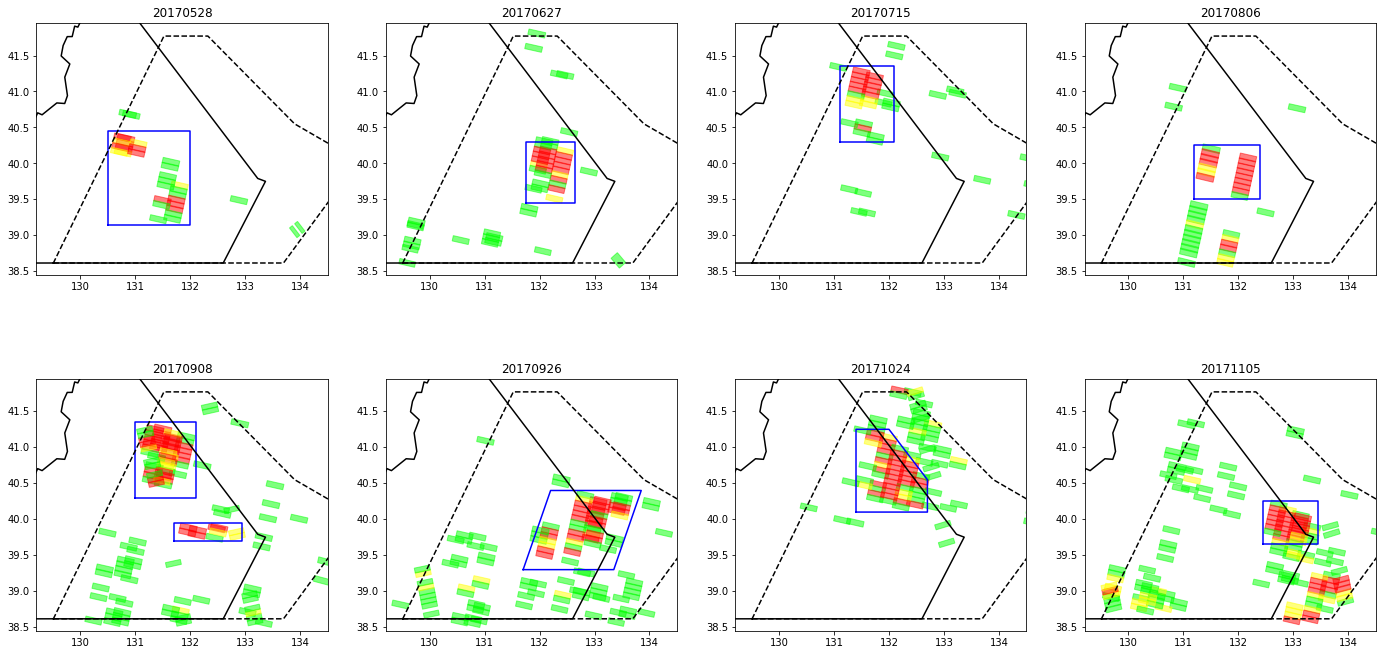

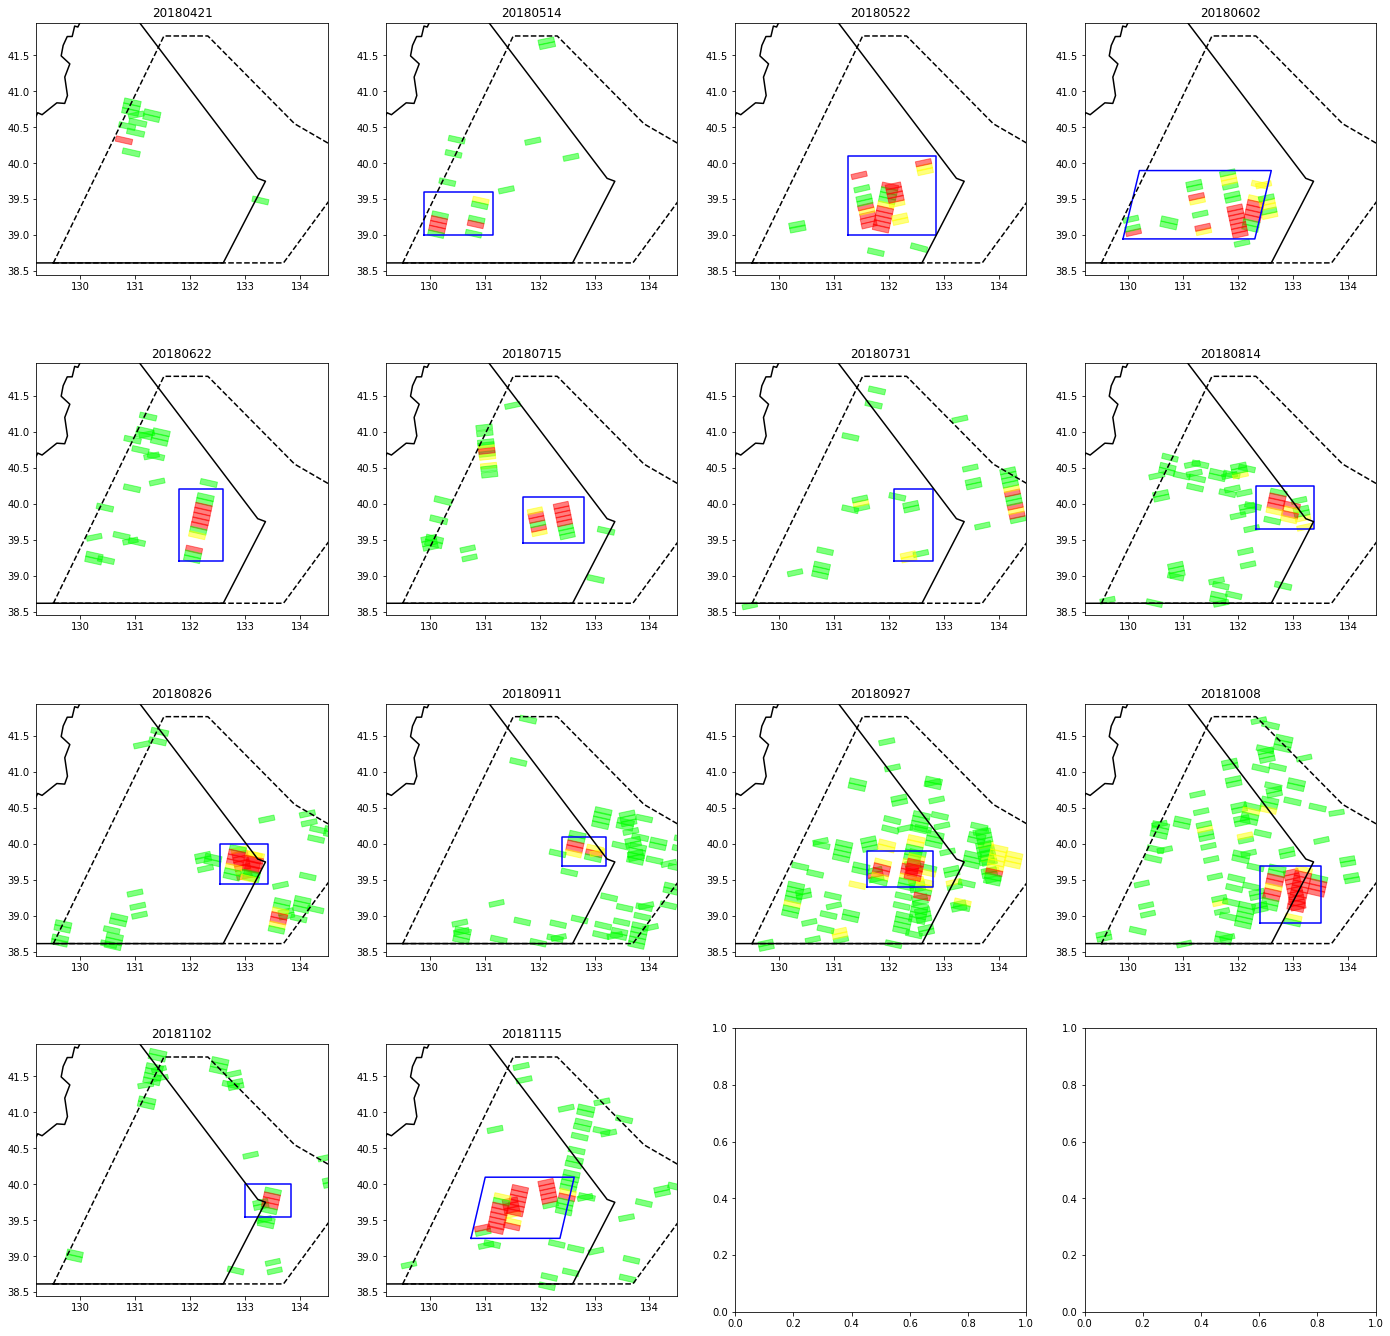

In [45]:
def plot_date_density(dates):
    n = len(dates)
    fig, axes = plt.subplots((n + 3) // 4, 4, figsize=(24, 6 * ((n + 3) // 4)))
    axes = axes.reshape(-1, 4)
    for i, date in enumerate(sorted(dates)):
        ax = axes[i // 4, i % 4]
        aois = aois_by_date.get(date, [])
        plot_scene_density(date, detections_map, ax, aois=aois_by_date[date])

plot_date_density(dates_2017)
plot_date_density(dates_2018)

In [46]:
def scenes_above_threshold(date, source, threshold, valid_pts):
    valid_poly = mplpath.Path(valid_pts)
    df = source[date]
    mask = valid_mask(df.latitude, df.longitude, valid_poly)
    counts = np.zeros_like(mask, dtype=int)
    soi_counts = np.zeros_like(mask, dtype=int)
    mask3 = np.zeros_like(mask)
    mask4 = np.zeros_like(mask)
    for j, x in enumerate(df.itertuples()):
        scene = x.scene_id
        if scene.endswith('Visual'):
            scene = scene.rsplit('_', 1)[0]
        si = scene_map[scene]
        bounds = json.loads(si.boundary)
        lons = [y['lon'] for y in bounds]
        lats = [y['lat'] for y in bounds]
        poly = mplpath.Path(np.transpose([lons, lats]))
        if (x.kind != 'dummy' and 
                not poly.contains_point([x.longitude, x.latitude])):
            print(x.scene_id, 'does not contain', x)
    aoi_pts = (mask & mask3).sum()
    soi_pts = (mask & mask4).sum()
    scenes_in_aoi = []
    all_scenes = []
    detect_pts = [(x.longitude, x.latitude) for x in df.itertuples()]
    target_scenes = []
    for scene in scene_map:
        if scene.startswith(date):
            si = scene_map[scene]
            bounds = json.loads(si.boundary)
            lons = [y['lon'] for y in bounds]
            lats = [y['lat'] for y in bounds]
            is_valid = any(valid_mask(lats, lons, valid_poly))
            scene_poly = mplpath.Path(np.transpose([lons, lats]))
            if len(detect_pts):
                contained_mask = (df.scene_id == scene)
                counts += contained_mask
                pts_in_scene = contained_mask.sum()
            else:
                pts_in_scene = 0
            if is_valid:
                all_scenes.append(scene)
                if pts_in_scene > threshold:
                    target_scenes.append(si.scene_id)
               
    return target_scenes



def scenes_above_threshold(date, source, threshold, valid_area=full_study_area):
    valid_poly = mplpath.Path(valid_area)
    df = source[date]
    target_scenes = []
    detect_pts = [(x.longitude, x.latitude) for x in df.itertuples()]  
    if len(detect_pts):
        for scene_id in scene_map:
            if scene_id.startswith(date):
                scene = scene_map[scene_id]
                lons, lats = lonlat_from_scene(scene)
                is_valid = any(counting_tools.create_valid_area_mask(lons, lats, valid_area))
                if is_valid:
                    pts_in_scene = (df.scene_id == scene_id).sum()
                    if pts_in_scene > threshold:
                        target_scenes.append(scene_id)
                    
    return target_scenes

In [47]:
def closest_scenes_to(date, lon, lat, count, threshold=4, ignore=()):
    dense_scene_ids = sorted(set(scenes_above_threshold(date, detections_map, threshold=threshold)))
    dense_scenes = [scene_map[x] for x in dense_scene_ids]
    lons = np.array([(x.lon_min + x.lon_max) / 2. for x in dense_scenes])
    lats = np.array([(x.lat_min + x.lat_max) / 2. for x in dense_scenes])
    bounds = [x.boundary for x in dense_scenes]
    dist2 = (lats - lat) ** 2 + (lons - lon) ** 2
    ndxs = np.argsort(dist2)
    return [(dense_scene_ids[i], lons[i], lats[i], bounds[i]) for i in ndxs[:count]]

def closest_scene_to(date, lon, lat, threshold=6, ignore=()):
    return closest_scenes_to(date, lon, lat, 1, threshold=threshold, ignore=ignore)[0]

def inspect(date, lon, lat, threshold=6, ignore=()):
    scene_id, lon, lat, boundary = closest_scene_to(date, lon, lat, threshold, ignore)
    fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
    aoi = [(x['lon'], x['lat']) for x in json.loads(boundary)]
    counting_tools.plot_date(date, detections_map, scene_map, ax1, aois=[aoi])
    datestr = scene_id[:8]
    subprocess.check_call(['gsutil', 'cp', '-n', 
        'gs://machine-learning-production/planet_paper/gpu_image_detections_1_1_aug'
         '/{}/detections/{}_3B_Visual.png'.format(datestr, scene_id),
        '../data/inspect_scratch/'])
    # Look at files on disk instead. The plots here are not deteailed enough to be useful
    # and make the notebook very big.
#     img = skio.imread('data/inspect_scratch/{}_3B_Visual.png'.format(scene_id))
#     plt.figure(figsize=(18,12))
#     plt.imshow(img)
#     plt.show()
    return scene_id

/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20170528_011237_1015


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20170528_011702_1031


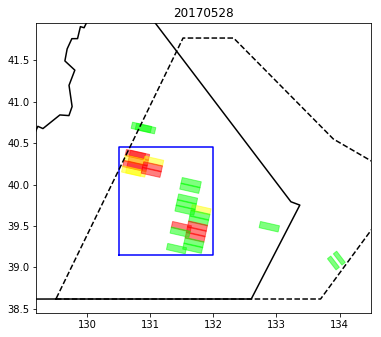

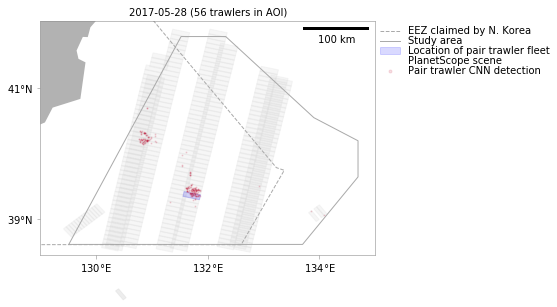

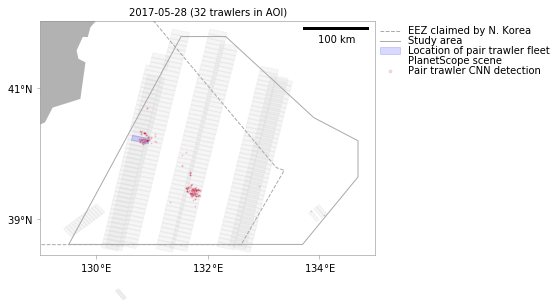

In [48]:
import imp
imp.reload(counting_tools)

fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
_ = plot_scene_density('20170528', detections_map, ax1, aois=aois_by_date['20170528'])
# These display the a specific scene on the map, if we have a marked up version of that scene,
# downloads the scene and prints the name. This is so we can inspect the high resolution scene
# outside of the notebook.
print(inspect('20170528', 131.5, 39.2, threshold=10))
print(inspect('20170528', 130.5, 40.2, threshold=10))
# Both of these look good, and chop is low, so use one AOI to encompase both regions.

/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


'20170627_011139_1014'

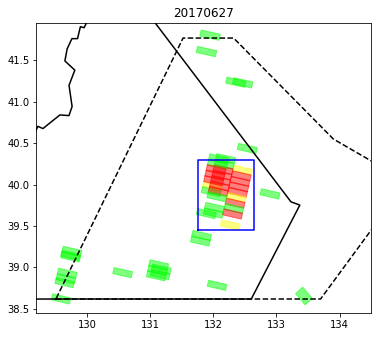

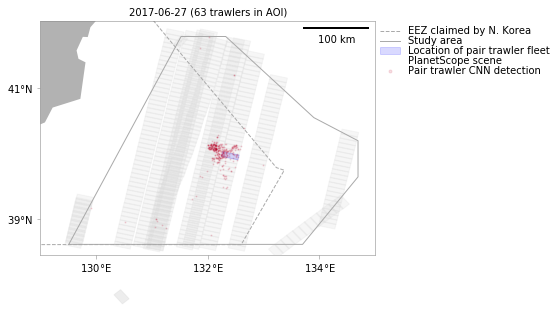

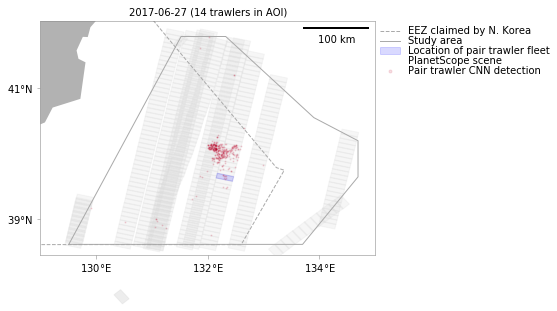

In [49]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
_ = plot_scene_density('20170627', detections_map, ax1, aois=aois_by_date['20170627'])
# These display the a specific scene on the map, if we have a marked up version of that scene,
# downloads the scene and prints the name. This is so we can inspect the high resolution scene
# outside of the notebook.
inspect('20170627', 132.3, 40.0, threshold=10)
inspect('20170627', 132.2, 39.5, threshold=6)
# Both of these look good, and chop is low, so use one AOI to encompase both regions.

/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


'20170715_011758_1033'

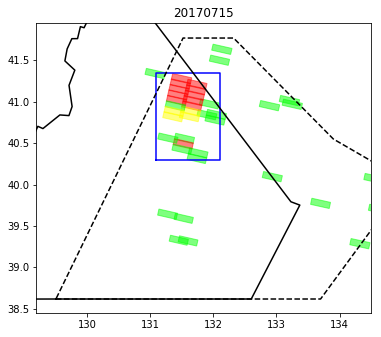

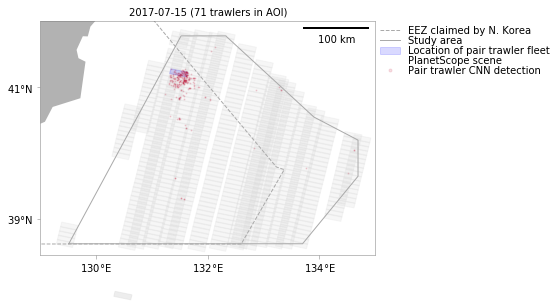

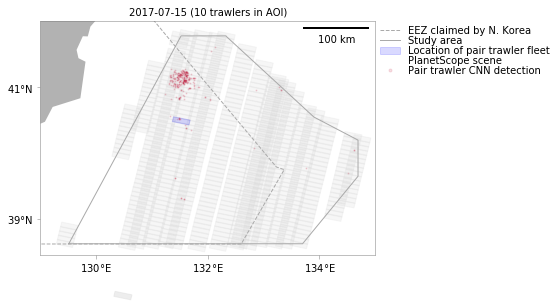

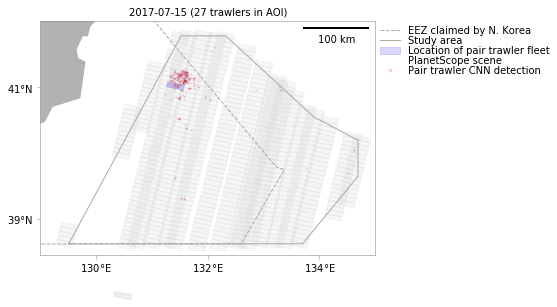

In [50]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
_ = plot_scene_density('20170715', detections_map, ax1, 
                       aois=aois_by_date['20170715'])
# These display the a specific scene on the map, if we have a marked up version of that scene,
# downloads the scene and prints the name. This is so we can inspect the high resolution scene
# outside of the notebook.
inspect('20170715', 131.5, 41.2, threshold=10)
inspect('20170715', 131.5, 39.5, threshold=4)
inspect('20170715', 131.5, 39.5, threshold=5, ignore=['20170715_011658_0f38', '20170715_011801_1033'])
# The top cluster is pair trawlers. The bottom cluster has lighting boats as well as pair trawlers, but can include
# due to improved lighting boat rejection.

/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


'20170806_011449_1006'

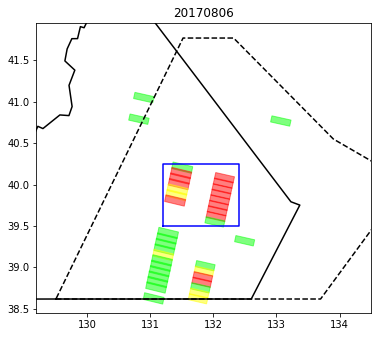

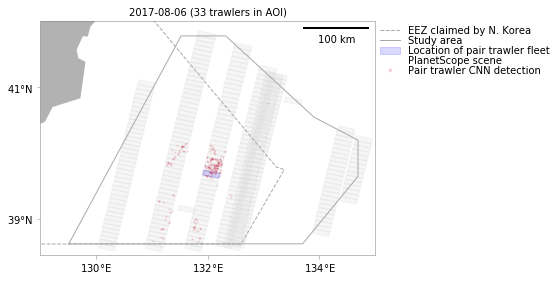

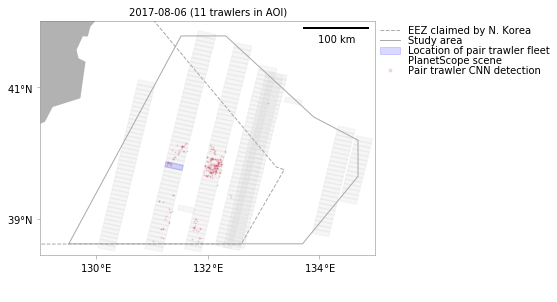

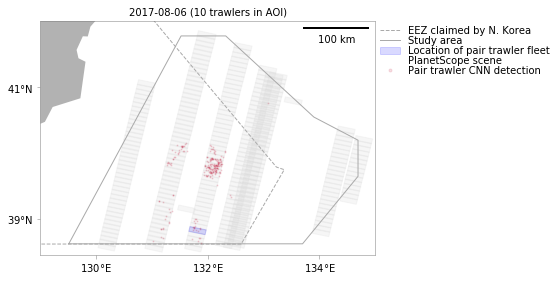

In [51]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
_ = plot_scene_density('20170806', detections_map, ax1, aois=aois_by_date['20170806'])
# These display the a specific scene on the map, if we have a marked up version of that scene,
# downloads the scene and prints the name. This is so we can inspect the high resolution scene
# outside of the notebook.
inspect('20170806', 132, 39.7, threshold=6)
inspect('20170806', 131., 39.7, threshold=4)
inspect('20170806', 131.8, 38.7, threshold=4)
# Top two clusters are trawlers, bottom is patchy clouds :-(

/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/timothyhochberg/anaconda

'20170908_011537_100b'

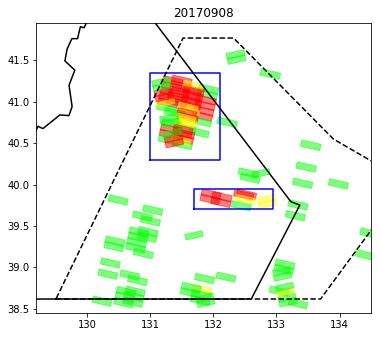

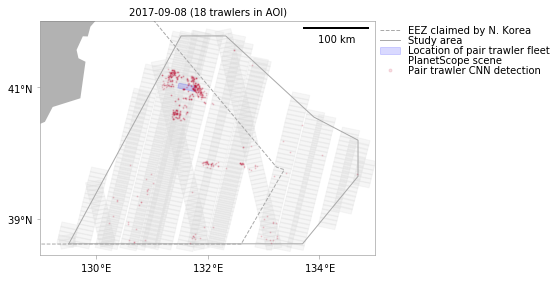

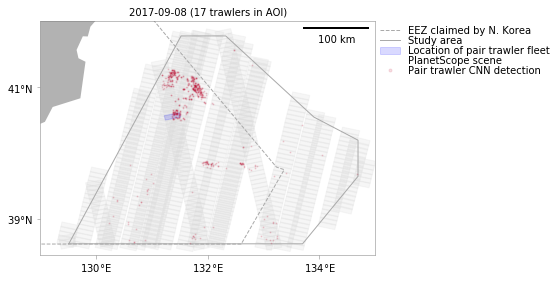

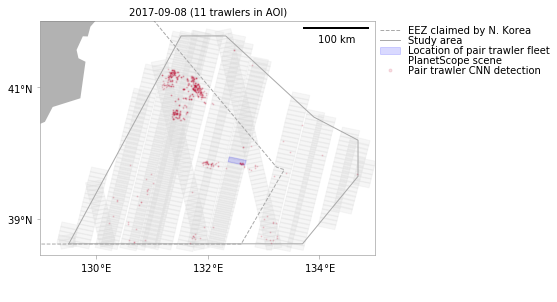

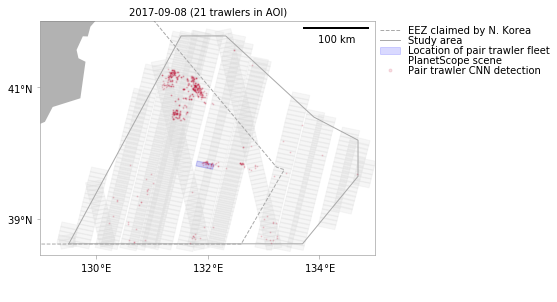

In [52]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
_ = plot_scene_density('20170908', detections_map, ax1,aois=aois_by_date['20170908'])
# These display the a specific scene on the map, if we have a marked up version of that scene,
# downloads the scene and prints the name. This is so we can inspect the high resolution scene
# outside of the notebook.
inspect('20170908', 131.5, 41, threshold=6) # Pair Trawlers
inspect('20170908', 131.3, 40.5, threshold=6) # Pair Trawlers
inspect('20170908', 132.5, 40., threshold=4) # Pair Trawlers
inspect('20170908', 132., 39.7, threshold=3) # Pair Trawlers

/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/timothyhochberg/anaconda

'20170926_011613_103d'

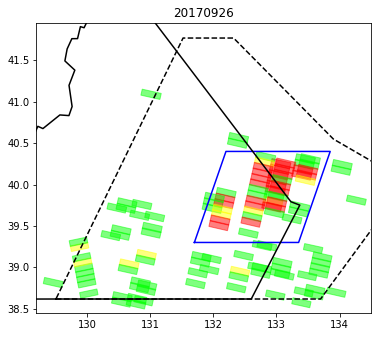

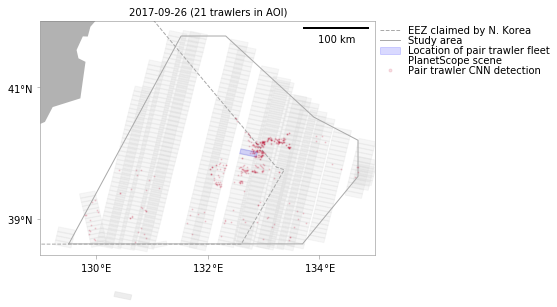

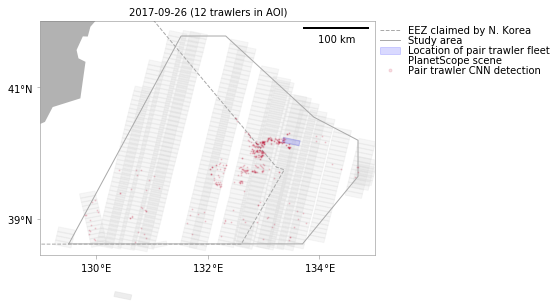

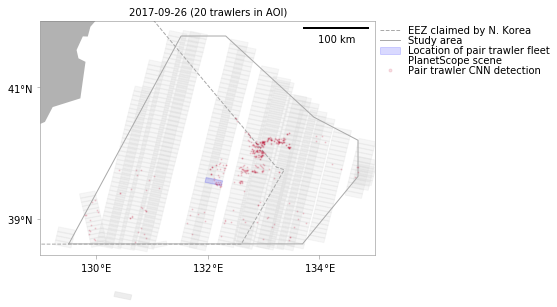

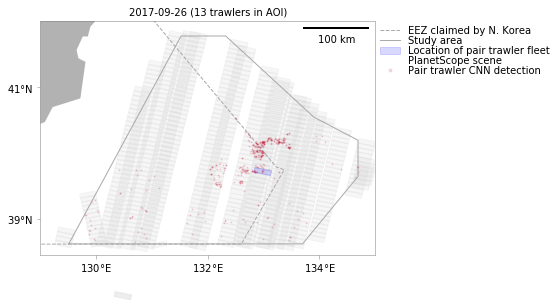

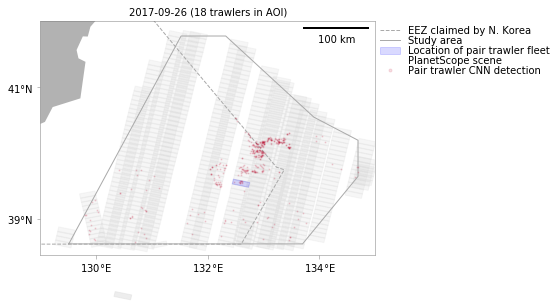

In [53]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
_ = plot_scene_density('20170926', detections_map, ax1, 
                       aois=aois_by_date['20170926'])
# These display the a specific scene on the map, if we have a marked up version of that scene,
# downloads the scene and prints the name. This is so we can inspect the high resolution scene
# outside of the notebook.
inspect('20170926', 132.5, 40, threshold=5) # Pair trawlers
inspect('20170926', 133.6, 40.2, threshold=5) # Pair Trawlers
inspect('20170926', 132, 39.5, threshold=5) # Pair trawlers
inspect('20170926', 133.5, 39.4, threshold=5) # Pair trawlers
inspect('20170926', 133, 39., threshold=5) # Pair trawlers & Lighting boats
# Use an angled AOI to avoid the non-PT boat clusters

/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


'20171024_011655_0f18'

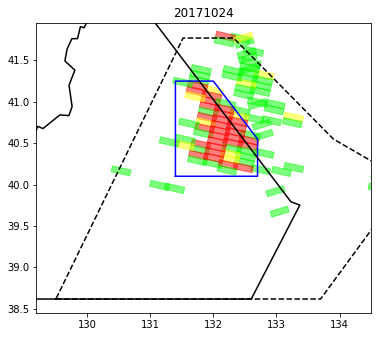

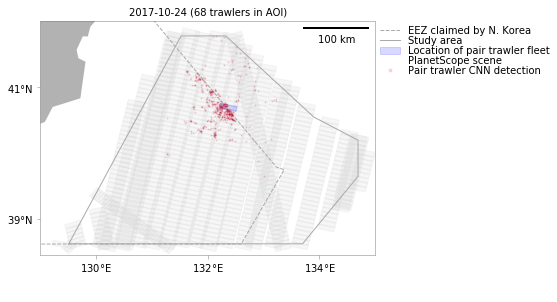

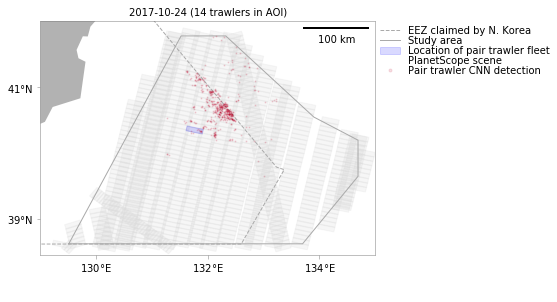

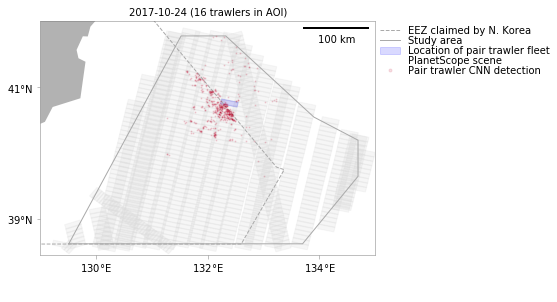

In [54]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
_ = plot_scene_density('20171024', detections_map, ax1, 
                       aois=aois_by_date['20171024'])
inspect('20171024', 132.5, 40.7, threshold=10) # Pair Trawlers
inspect('20171024', 131.8, 40.4, threshold=6) # Pair Trawlers
inspect('20171024', 133, 41.4, threshold=6) # Pair Trawlers

/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20171105_011655_101b


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20171105_011700_101b


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20171105_011605_103c


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20171105_011118_0f34


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20171105_012757_0f38


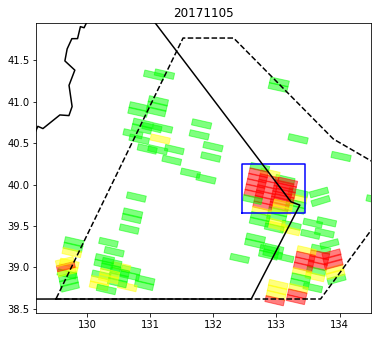

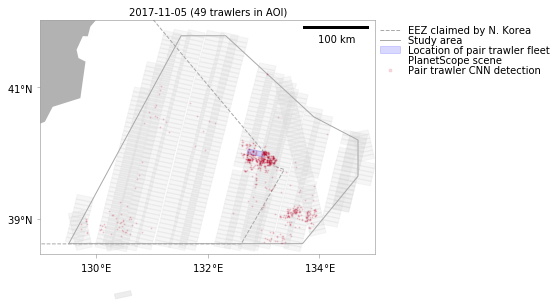

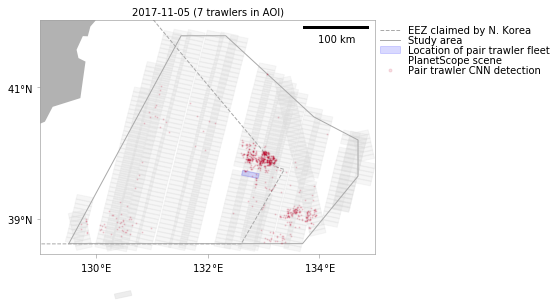

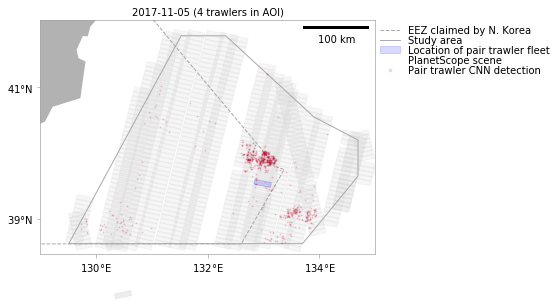

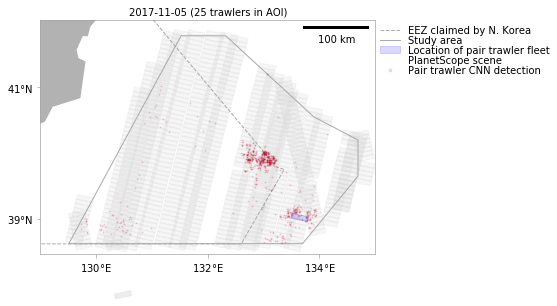

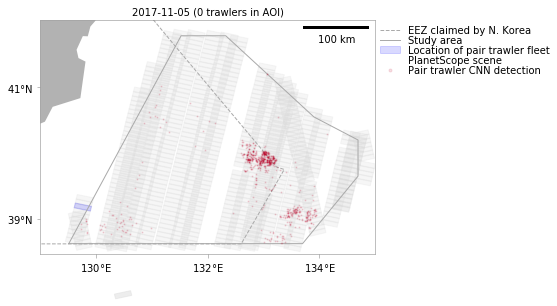

In [55]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
_ = plot_scene_density('20171105', detections_map, ax1, aois=aois_by_date['20171105'])
# These display the a specific scene on the map, if we have a marked up version of that scene,
# downloads the scene and prints the name. This is so we can inspect the high resolution scene
# outside of the notebook.
print(inspect('20171105', 132.8, 40.0, threshold=10)) # Pair Trawlers
print(inspect('20171105', 132.8, 39.5, threshold=3)) # Pair Trawlers (3) + patch clouds (1)
print(inspect('20171105', 133, 39.5, threshold=3)) # Pair Trawlers
print(inspect('20171105', 133.6, 39.0, threshold=3)) # Crazy tiny clouds
print(inspect('20171105', 130.5, 39.1, threshold=3)) # Chop

/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180421_013046_1009


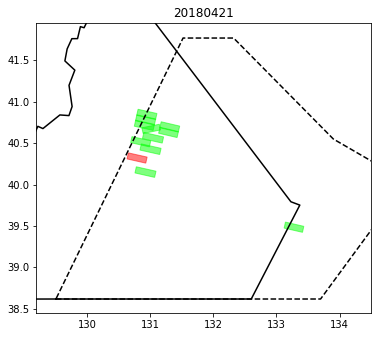

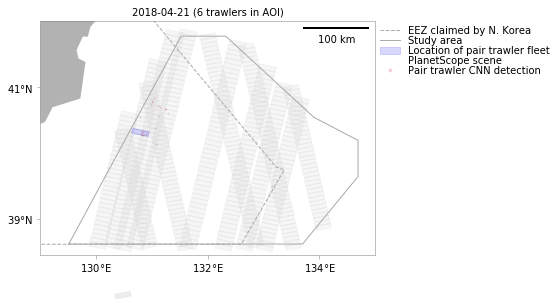

In [56]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
_ = plot_scene_density('20180421', detections_map, ax1, aois=[])
# These display the a specific scene on the map, if we have a marked up version of that scene,
# downloads the scene and prints the name. This is so we can inspect the high resolution scene
# outside of the notebook.
print(inspect('20180421', 131.0, 40.2, threshold=5)) # chop
# No fleet found

/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180514_013333_1012


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180514_013000_100a


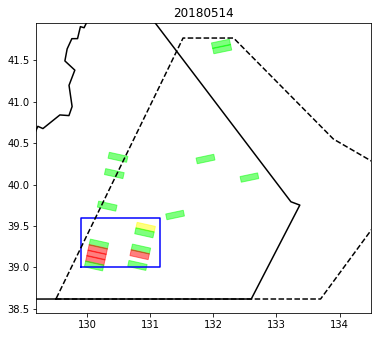

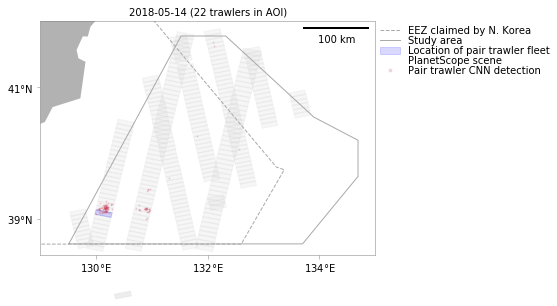

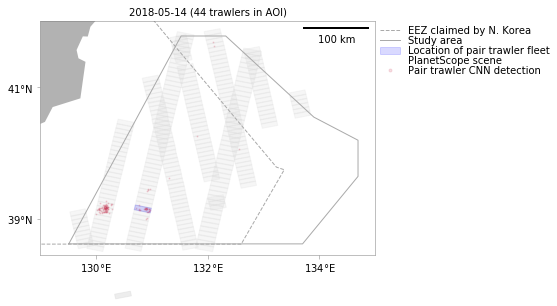

In [57]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
_ = plot_scene_density('20180514', detections_map, ax1, aois=aois_by_date['20180514'])
# These display the a specific scene on the map, if we have a marked up version of that scene,
# downloads the scene and prints the name. This is so we can inspect the high resolution scene
# outside of the notebook.
print(inspect('20180514', 130.1, 39.1, threshold=6)) # pair trawlers
print(inspect('20180514', 131, 39.1, threshold=6)) #  pair trawlers

/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180522_012622_1002


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180522_012949_0f49


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180522_012723_0f2b


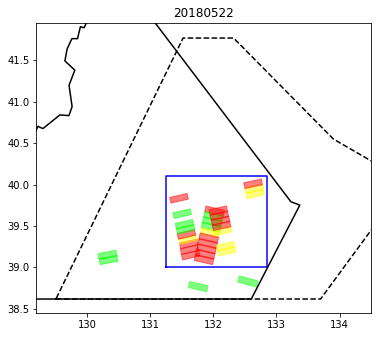

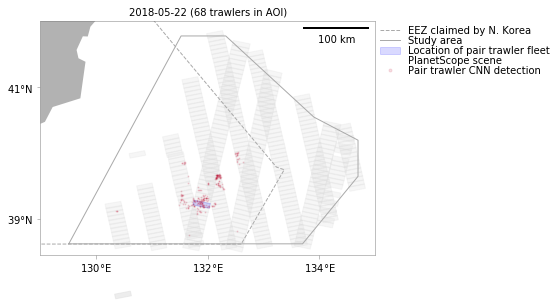

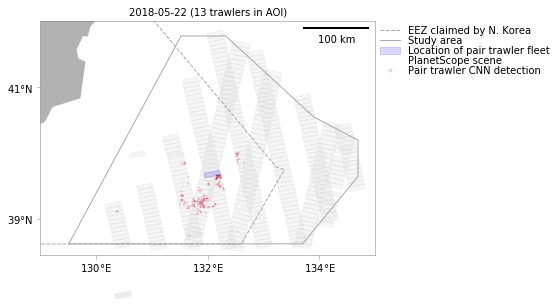

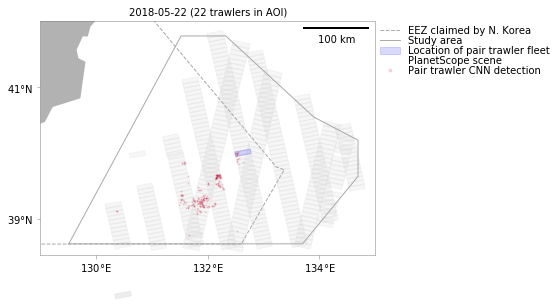

In [58]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
_ = plot_scene_density('20180522', detections_map, ax1,                        
                       aois=aois_by_date['20180522'])
# These display the a specific scene on the map, if we have a marked up version of that scene,
# downloads the scene and prints the name. This is so we can inspect the high resolution scene
# outside of the notebook.
print(inspect('20180522', 131.9, 39.2, threshold=6)) # pair trawlers -- already annotated
print(inspect('20180522', 132.2, 39.7, threshold=6)) # Pair trawlers -- already annotated
print(inspect('20180522', 132.5, 40.0, threshold=6)) # Pair Trawlers

/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180602_012902_0f2d


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180602_013140_0f29


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180602_013146_0f29


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180602_013640_0f49


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180602_012640_1053


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180602_012647_1053


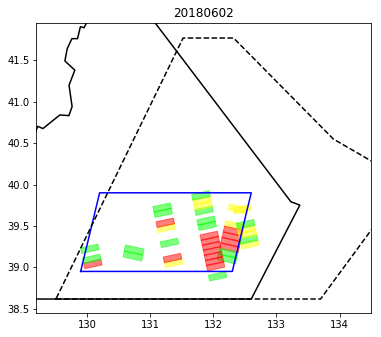

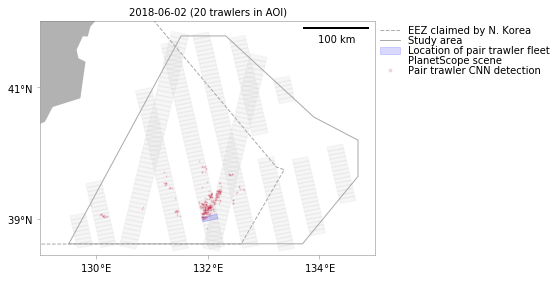

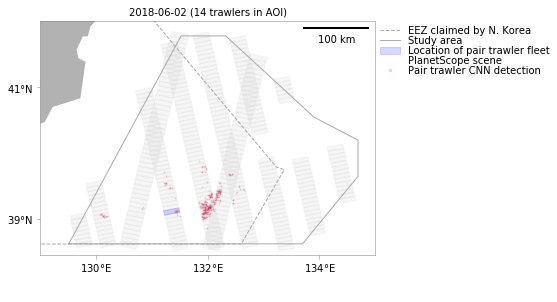

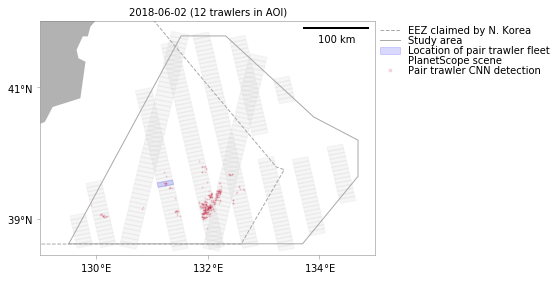

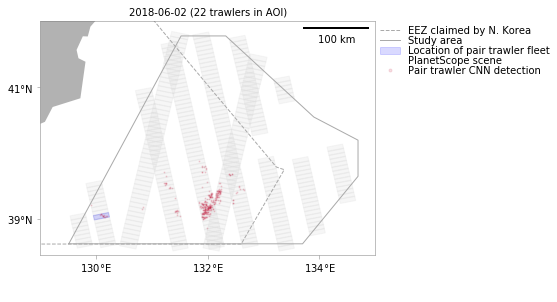

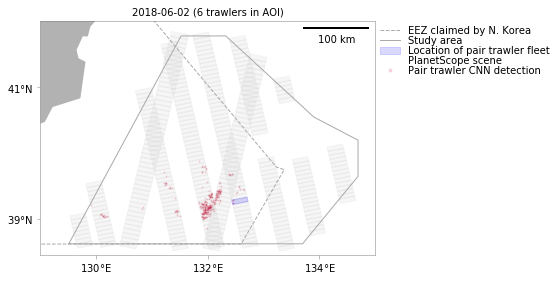

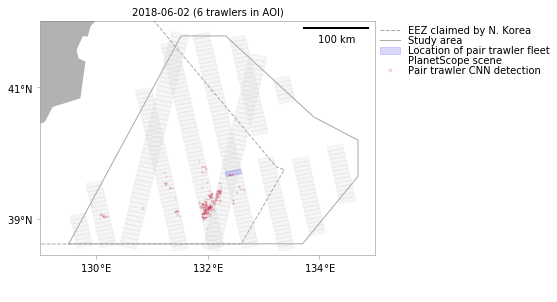

In [59]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
_ = plot_scene_density('20180602', detections_map, ax1, 
                       aois=aois_by_date['20180602'])
# These display the a specific scene on the map, if we have a marked up version of that scene,
# downloads the scene and prints the name. This is so we can inspect the high resolution scene
# outside of the notebook.
print(inspect('20180602', 132., 39.0, threshold=6)) # Pair Trawlers
print(inspect('20180602', 131.3, 39.0, threshold=6)) # Pair Trawlers
print(inspect('20180602', 131.1, 39.5, threshold=3)) # Pair Trawlers
print(inspect('20180602', 130.0, 39.0, threshold=6)) # Pair Trawlers
print(inspect('20180602', 132.5, 39.3, threshold=2)) # Patchy clouds
print(inspect('20180602', 132.5, 39.7, threshold=2)) # # Pair trawlers

/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180622_012714_1027


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180622_012718_1027


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180622_012724_1027


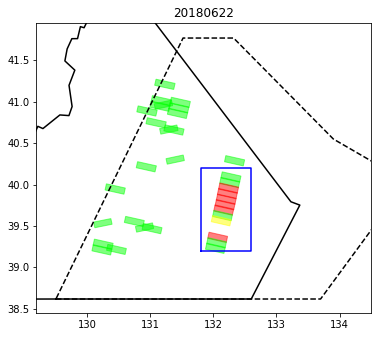

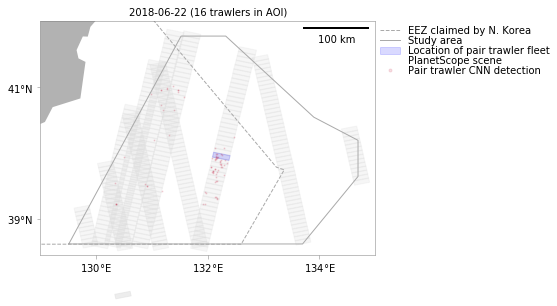

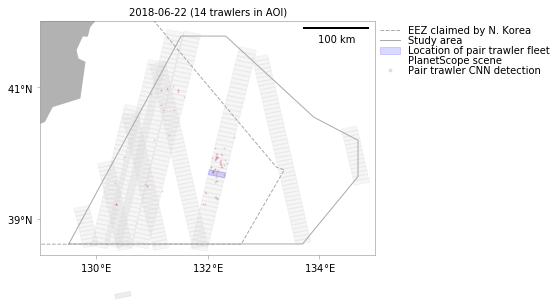

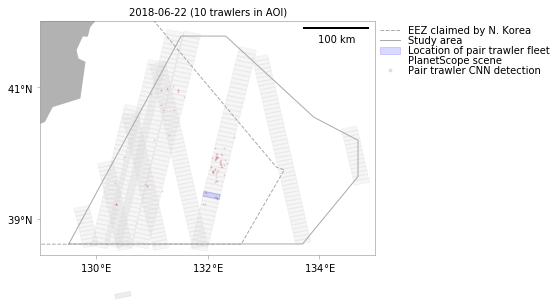

In [60]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
_ = plot_scene_density('20180622', detections_map, ax1, aois=aois_by_date['20180622'])
# These display the a specific scene on the map, if we have a marked up version of that scene,
# downloads the scene and prints the name. This is so we can inspect the high resolution scene
# outside of the notebook.
print(inspect('20180622', 132.1, 40.0, threshold=3)) # Pair trawlers
print(inspect('20180622', 132.1, 39.7, threshold=3)) # Pair trawlers
print(inspect('20180622', 132., 39.3, threshold=3)) # Pair trawlers

/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180715_012247_0f32


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180715_050054_1_0f1c


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180715_012055_0f36


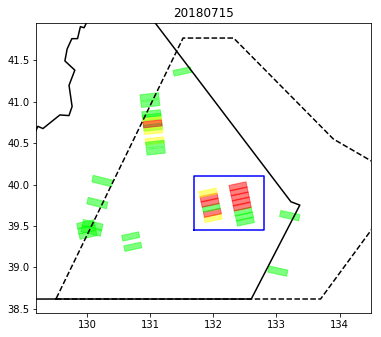

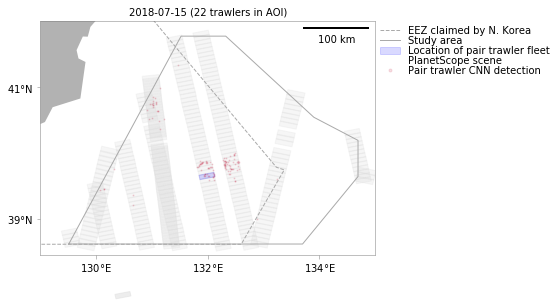

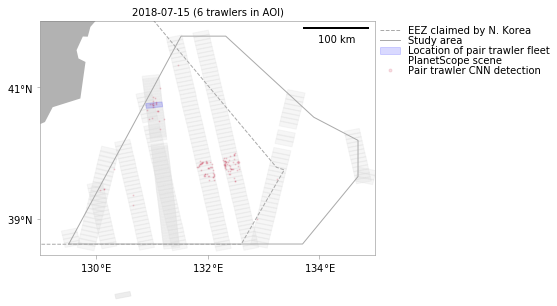

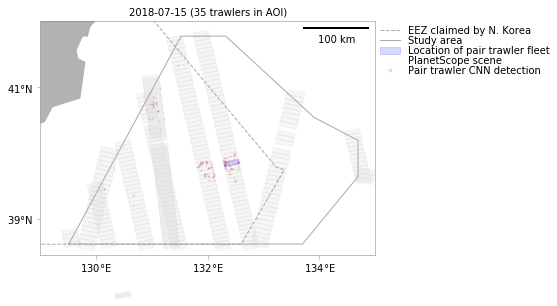

In [61]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
_ = plot_scene_density('20180715', detections_map, ax1, aois=aois_by_date['20180715'])
# These display the a specific scene on the map, if we have a marked up version of that scene,
# downloads the scene and prints the name. This is so we can inspect the high resolution scene
# outside of the notebook.
print(inspect('20180715', 132.1, 39.7, threshold=3)) # Pair Trawlers
print(inspect('20180715', 130.8, 40.7, threshold=3)) # Clouds + waves
print(inspect('20180715', 132.5, 39.9, threshold=3)) # Pair Trawlers

/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180731_011855_0f4b


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180731_011855_0f4b


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180731_011856_0f4b


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180731_012147_0f49


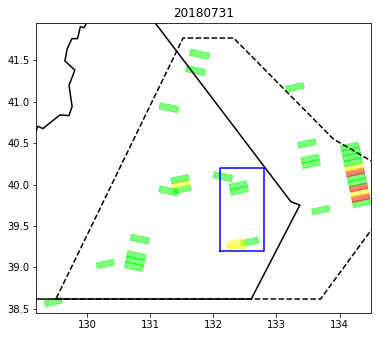

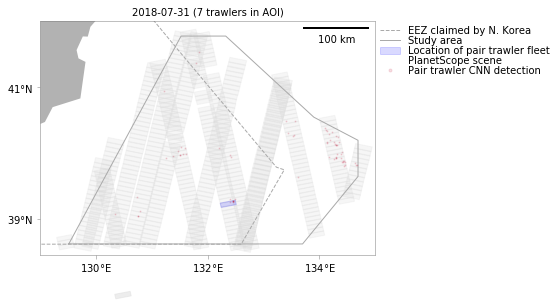

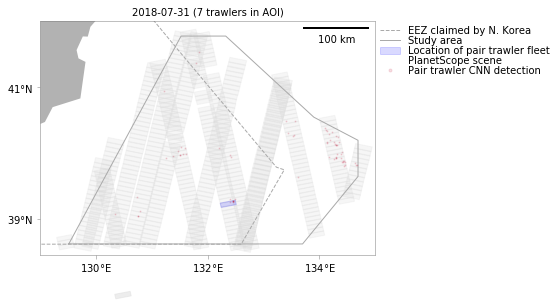

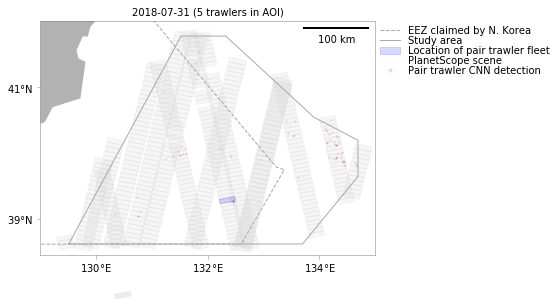

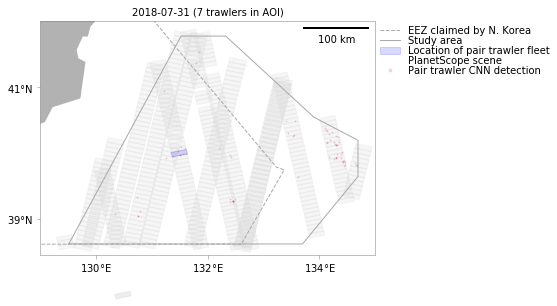

In [62]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
_ = plot_scene_density('20180731', detections_map, ax1, aois=aois_by_date['20180731'])
# These display the a specific scene on the map, if we have a marked up version of that scene,
# downloads the scene and prints the name. This is so we can inspect the high resolution scene
# outside of the notebook.
print(inspect('20180731', 132.5, 39.3, threshold=3)) # Paired and singleton trawlers
print(inspect('20180731', 132.5, 39.3, threshold=3)) # Clouds
print(inspect('20180731', 132.5, 39.8, threshold=1)) # Paired and singleton trawlers
print(inspect('20180731', 131.2, 39.8, threshold=3)) # Clouds

/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180814_012648_1035


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180814_012556_1014


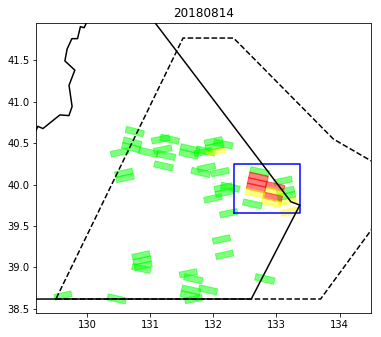

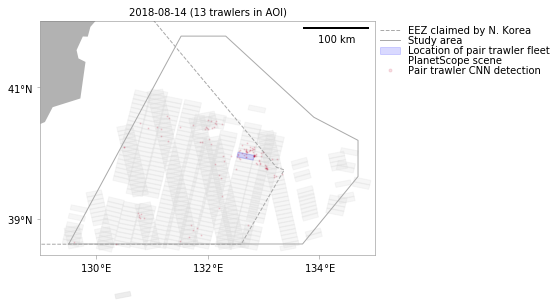

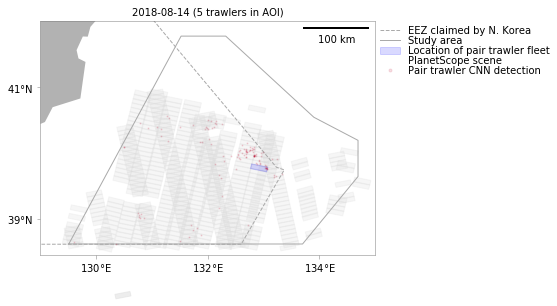

In [63]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
_ = plot_scene_density('20180814', detections_map, ax1, aois=aois_by_date['20180814'])
# These display the a specific scene on the map, if we have a marked up version of that scene,
# downloads the scene and prints the name. This is so we can inspect the high resolution scene
# outside of the notebook.
print(inspect('20180814', 132.5, 40.0, threshold=6)) # pair trawlers
print(inspect('20180814', 132.8, 39.6, threshold=3)) # pair trawlers

/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180826_012727_0f28


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180826_012339_0f43


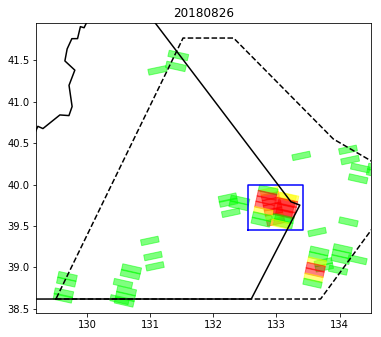

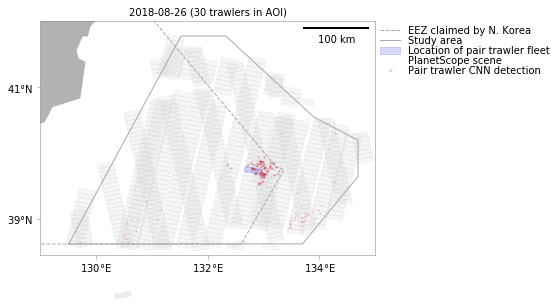

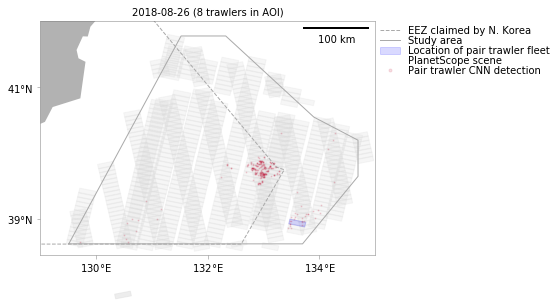

In [64]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
_ = plot_scene_density('20180826', detections_map, ax1, aois=aois_by_date['20180826'])
# These display the a specific scene on the map, if we have a marked up version of that scene,
# downloads the scene and prints the name. This is so we can inspect the high resolution scene
# outside of the notebook.
print(inspect('20180826', 132.8, 39.6, threshold=6)) # Pair trawlers
print(inspect('20180826', 133.7, 38.6, threshold=3)) # Clouds + chop

/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180911_012820_1006


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180911_012651_1040


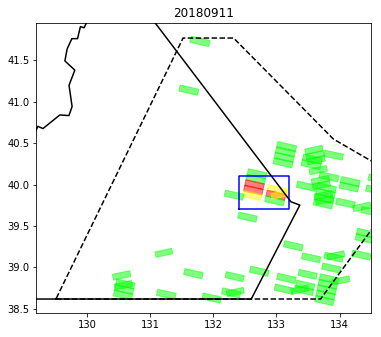

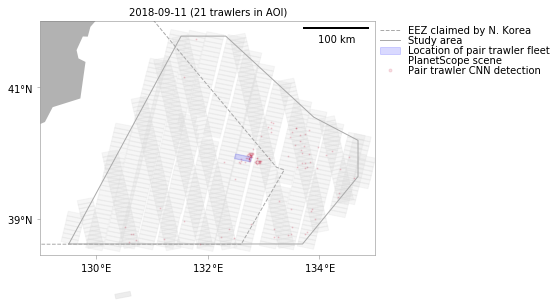

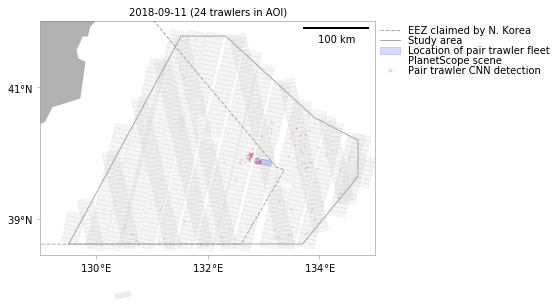

In [65]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
_ = plot_scene_density('20180911', detections_map, ax1, aois=aois_by_date['20180911'])
# These display the a specific scene on the map, if we have a marked up version of that scene,
# downloads the scene and prints the name. This is so we can inspect the high resolution scene
# outside of the notebook.
print(inspect('20180911', 132.5, 40.0, threshold=6)) # Pair trawlers
print(inspect('20180911', 132.8, 38.7, threshold=6)) # Pair trawlers

/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180927_043515_0f4c


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180927_013138_100a


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180927_012817_1015


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180927_010330_0f4a


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20180927_013317_1012


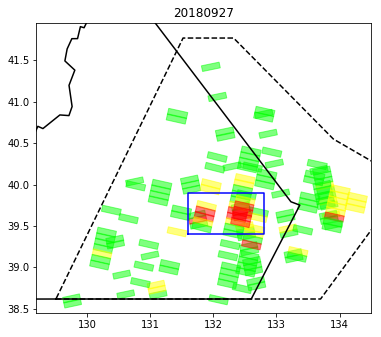

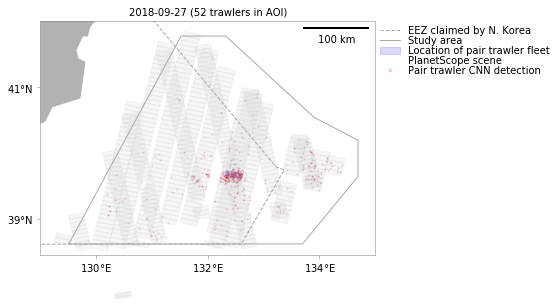

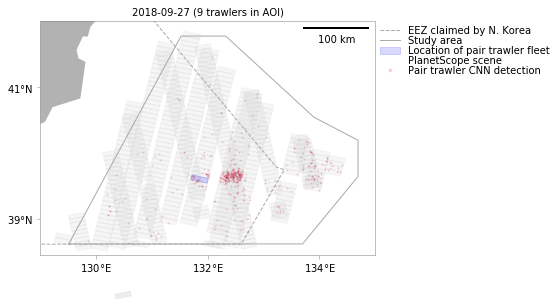

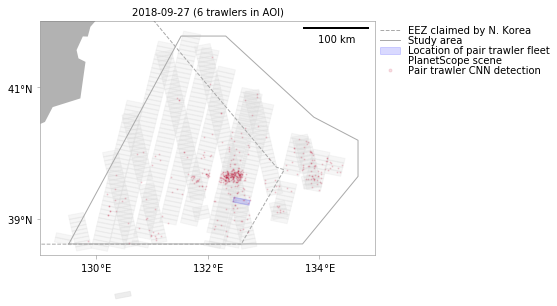

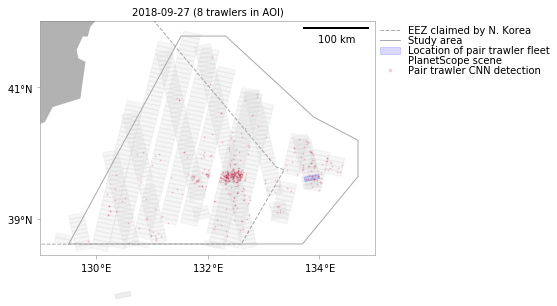

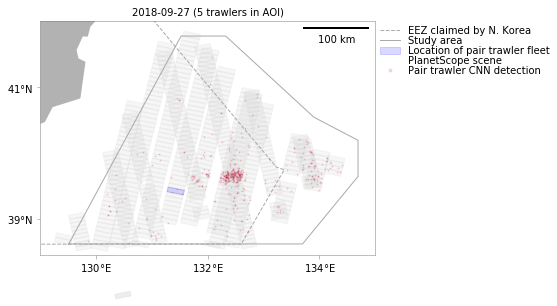

In [66]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
_ = plot_scene_density('20180927', detections_map, ax1, aois=aois_by_date['20180927'])
# These display the a specific scene on the map, if we have a marked up version of that scene,
# downloads the scene and prints the name. This is so we can inspect the high resolution scene
# outside of the notebook.
print(inspect('20180927', 132.5, 39.7, threshold=3)) # Pair trawlers
print(inspect('20180927', 131.5, 39.6, threshold=6)) # Pair trawlers
print(inspect('20180927', 132.5, 39.2, threshold=3)) # Chop + cloud + 1? pair trawler pair
print(inspect('20180927', 133.8, 39.6, threshold=3)) # Chop + some sort of boat?
print(inspect('20180927', 131.4, 39.4, threshold=2)) # Clouds

/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20181008_010608_1052


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20181008_012532_1014


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20181008_012910_0f22


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20181008_012913_0f22


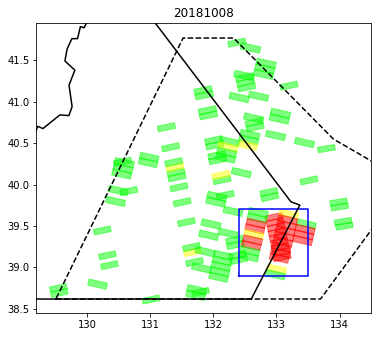

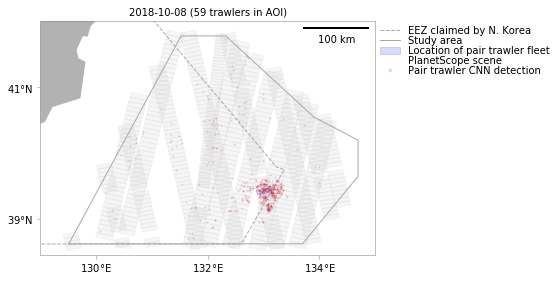

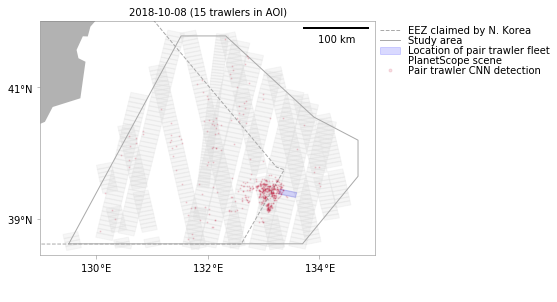

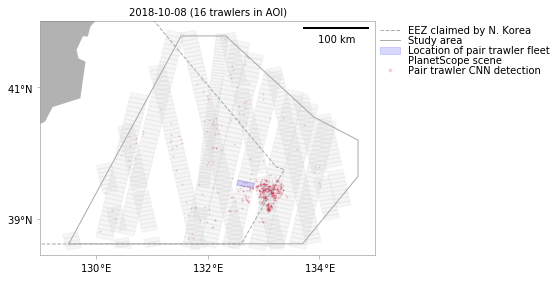

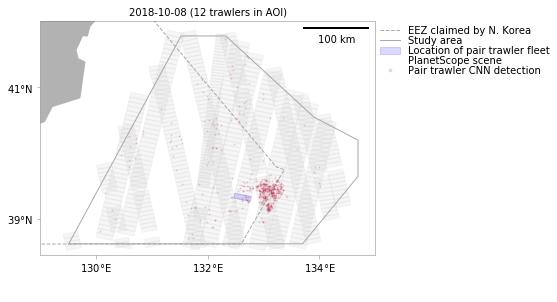

In [67]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
_ = plot_scene_density('20181008', detections_map, ax1, aois=
                       aois_by_date['20181008'])
# These display the a specific scene on the map, if we have a marked up version of that scene,
# downloads the scene and prints the name. This is so we can inspect the high resolution scene
# outside of the notebook.
print(inspect('20181008', 132.9, 39.4, threshold=3)) # Pair trawlers
print(inspect('20181008', 133.3, 39.4, threshold=3)) # Pair trawlers
print(inspect('20181008', 132.5, 39.6, threshold=3)) # Pair trawlers
print(inspect('20181008', 132.5, 39.4, threshold=3)) # Pair trawlers

/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20181102_012647_0f42


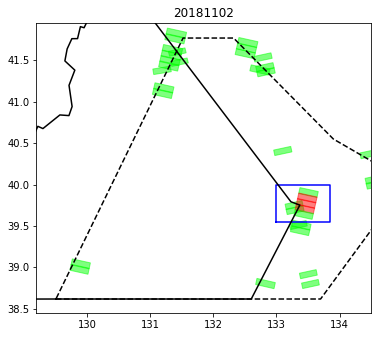

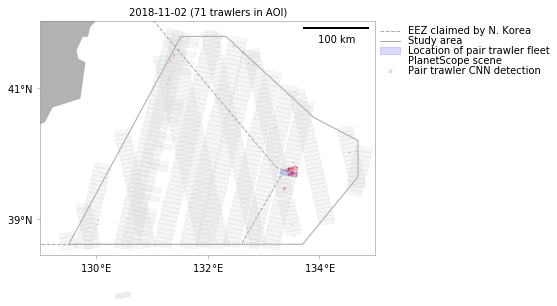

In [68]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
_ = plot_scene_density('20181102', detections_map, ax1, aois=
                       aois_by_date['20181102'])
# These display the a specific scene on the map, if we have a marked up version of that scene,
# downloads the scene and prints the name. This is so we can inspect the high resolution scene
# outside of the notebook.
print(inspect('20181102', 133.5, 39.7, threshold=6)) # Pair trawlers

/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20181115_013459_100c


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20181115_013359_1009


/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20181115_010333_104a


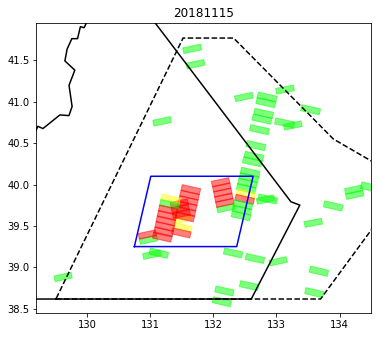

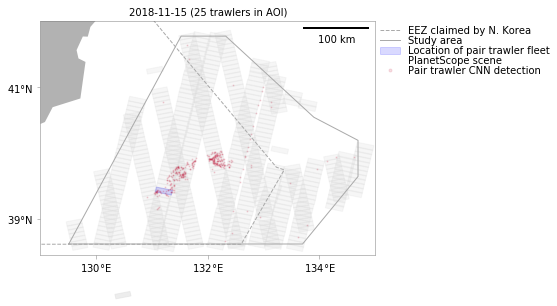

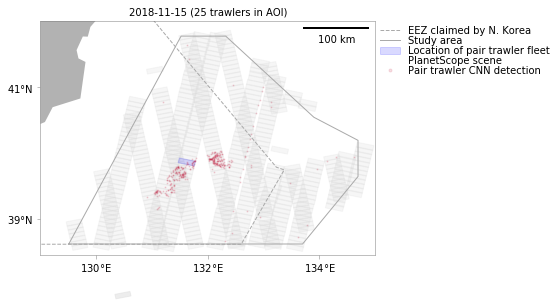

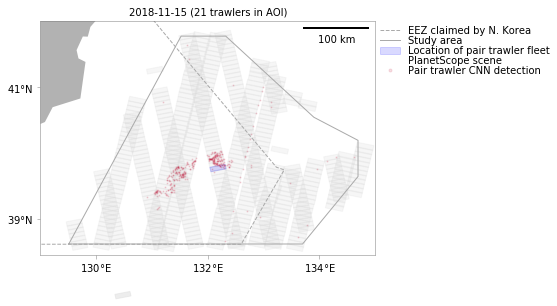

In [69]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
_ = plot_scene_density('20181115', detections_map, ax1, 
                       aois=aois_by_date['20181115'])
# These display the a specific scene on the map, if we have a marked up version of that scene,
# downloads the scene and prints the name. This is so we can inspect the high resolution scene
# outside of the notebook.
print(inspect('20181115', 131.1, 39.6, threshold=8)) # Pair trawlers
print(inspect('20181115', 131.5, 39.9, threshold=8)) # Pair trawlers
print(inspect('20181115', 132.3, 39.7, threshold=8)) # pair trawlers